In [1]:
%matplotlib inline

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from scipy.sparse import hstack

from sklearn.neural_network import MLPClassifier

# Train set

In [3]:
df_train = pd.read_csv('train.csv.zip')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
print('Train set size: {}'.format(len(df_train)))
q1_train_empty = df_train['question1'].isnull().values
q2_train_empty = df_train['question2'].isnull().values
if q1_train_empty.any():
    print('Indices of data points where `question1` is empty:')
    print(np.where(q1_train_empty == True))
if q2_train_empty.any():
    print('Indices of data points where `question2` is empty:')
    print(np.where(q2_train_empty == True))

Train set size: 404290
Indices of data points where `question2` is empty:
(array([105780, 201841]),)


# Test set

In [5]:
df_test = pd.read_csv('test.csv.zip')
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [6]:
print('Train set size: {}'.format(len(df_train)))
q1_test_empty = df_test['question1'].isnull().values
q2_test_empty = df_test['question2'].isnull().values
if q1_test_empty.any():
    print('Indices of data points where `question1` is empty:')
    print(np.where(q1_test_empty == True))
if q2_test_empty.any():
    print('Indices of data points where `question2` is empty:')
    print(np.where(q2_test_empty == True))

Train set size: 404290
Indices of data points where `question1` is empty:
(array([1046690, 1461432]),)
Indices of data points where `question2` is empty:
(array([ 379205,  817520,  943911, 1270024]),)


# Features

In [7]:
from nltk.corpus import stopwords

In [8]:
# Why cannot I use this function?
def words(row, qid):
    str(row['question{}'.format(qid)]).lower().split()

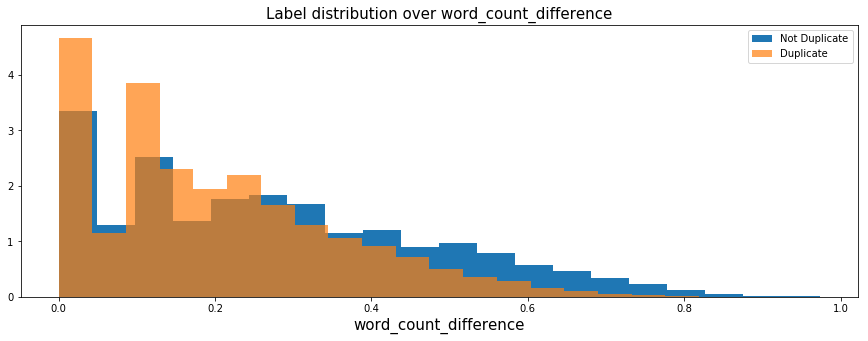

In [9]:
def word_count_difference(row):
    length1 = len(str(row['question1']).lower().split())
    length2 = len(str(row['question2']).lower().split())
    return abs(length1 - length2) / max(length1, length2)

plt.figure(figsize = (15, 5))
train_word_match = df_train.apply(word_count_difference, axis = 1, raw = True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins = 20, normed = True, label = 'Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins = 20, normed = True, alpha = 0.7, label = 'Duplicate')
plt.legend()
plt.title('Label distribution over word_count_difference', fontsize = 15)
plt.xlabel('word_count_difference', fontsize = 15)

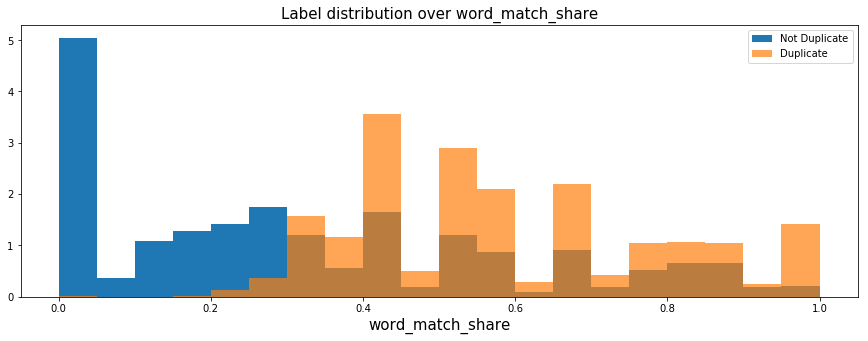

In [10]:
stops = set(stopwords.words('english'))

def word_match_share(row):
    q1words = {}
    q2words = {}      
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2)) / (len(q1words) + len(q2words))
    return R

plt.figure(figsize = (15, 5))
train_word_match = df_train.apply(word_match_share, axis = 1, raw = True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins = 20, normed = True, label = 'Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins = 20, normed = True, alpha = 0.7, label = 'Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize = 15)
plt.xlabel('word_match_share', fontsize = 15)

## sklearn.feature_extraction.text

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# drop empty strings
df_train.dropna(inplace=True)

vectorizer = HashingVectorizer(stop_words = 'english', non_negative = True, n_features = 10)
X1_train = vectorizer.transform(df_train['question1'])
X2_train = vectorizer.transform(df_train['question2'])
y_train = df_train['is_duplicate']

In [16]:
X_train = hstack([X1_train, X2_train])

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [19]:
q1_null_indices = np.where(df_test['question1'].isnull().values == True)
q2_null_indices = np.where(df_test['question2'].isnull().values == True)

dummy = 'xxxxxxxxxxxxx'

for i in q1_null_indices:
    df_test.loc[i, 'question1'] = dummy
for i in q2_null_indices:
    df_test.loc[i, 'question2'] = dummy

X1_test = vectorizer.transform(df_test['question1'])
X2_test = vectorizer.transform(df_test['question2'])
X_test = hstack([X1_test, X2_test])

In [21]:
y_test = clf.predict(X_test)
print(y_test.size)

2345796


In [24]:
for i in q1_null_indices:
    y_test[i] = 0
for i in q2_null_indices:
    y_test[i] = 0

In [26]:
sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = y_test
sub.to_csv('hash-mlp.csv', index=False)